In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator

In [2]:
MOCA_THRESHOLD = 24.5
MMSE_THRESHOLD = 28.5

In [3]:
significant_prs = [
    'GRS__savage_2018__intelligence.txt',
    'GRS__lee_2018__cognitive_performance.txt',
    'GRS__lee_2018__educational_attainment.txt',
    'GRS__davies_2016__reasoning.txt'
]

titles = [
    'Intelligence PRS',
    'Cognitive performance PRS',
    'Educational attainment PRS',
    'Reasoning PRS'
]

In [4]:
def compute_age_dementia(df, age_variable, cognition_variable, threshold):
    df_new = df.sort_values(age_variable).copy()
    df_new = df_new[df_new[cognition_variable] < threshold]
    if df_new.size == 0:
        return pd.Series([False, df[age_variable].max()])
    else:
        return pd.Series([True, df_new[age_variable].min()])

# DIGPD

In [5]:
df_digpd = pd.read_excel('DIGPD data/dig_pd_2019_11.xlsx')
df_digpd['PATNO'] = df_digpd['PATIENT'].apply(lambda x: x[:5]).astype('int64')
df_digpd = df_digpd[df_digpd['PATNO'].isin(np.loadtxt('DIGPD - final list of subjects.txt', dtype=int))]

df_grs_digpd = pd.read_csv('LDpred2 - Results/GRS - DIGPD.csv', index_col=0)
df_grs_digpd = df_grs_digpd.sub(df_grs_digpd.mean(axis=0)).div(df_grs_digpd.std(axis=0))

In [6]:
def plot_kaplan_meier_curves_digpd(df, df_grs):
    series_age_diag = df_digpd.groupby('PATNO')['Age_diag'].min()
    series_baseline = df.groupby('PATNO')['AgeInclusion'].min()
    
    # Compute status and age at dementia
    df_dementia = df[~df['ScoreMMSE_Corrige'].isna()].copy()
    df_dementia = df_dementia.groupby('PATNO')[['Age', 'ScoreMMSE_Corrige']].apply(
        compute_age_dementia, 'Age', 'ScoreMMSE_Corrige', MMSE_THRESHOLD
    )
    df_dementia.columns = ['Status', 'Time']

    # Compute the quartiles for each GRS
    df_grs_quartiles = pd.DataFrame([
        pd.qcut(df_grs[col], 4, labels=False).squeeze() for col in significant_prs
    ]).T
    
    # Concatenate the objects
    df_new = pd.concat((series_age_diag, series_baseline, df_dementia, df_grs_quartiles), axis=1, join='inner')
    df_new['Time since diagnosis'] = df_new['Time'] - df_new['Age_diag']
    df_new['Time since baseline'] = df_new['Time'] - df_new['AgeInclusion']
    
    print("Number of PD subjects =", df_new.shape[0])
    print()
    print(df_new['Status'].value_counts())
    
    # Plot Kaplan-Meier curves
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw={'hspace': 0.4})
    
    for i, (col, title) in enumerate(zip(significant_prs, titles)):
        idx = divmod(i, 2)
        
        for j, label in enumerate(['First quartile', 'Second quartile', 'Third quartile', 'Fourth quartile']):
            mask = (df_new[col] == j)

            axes[idx].step(*kaplan_meier_estimator(
                df_new.loc[mask, 'Status'],
                df_new.loc[mask, 'Time since diagnosis'].round(),
                df_new.loc[mask, 'Time since baseline'].round()
            ), where="post", label=label)

        axes[idx].legend()
        axes[idx].set_title(title)
        axes[idx].set_ylabel("Probability of not having\nany cognitive disorder yet")
        axes[idx].set_xlabel("Time since PD diagnosis (in years)")
    
    fig.savefig('Survival plots (DIGPD).png', bbox_inches='tight', dpi=600)

Number of PD subjects = 387

True     325
False     62
Name: Status, dtype: int64


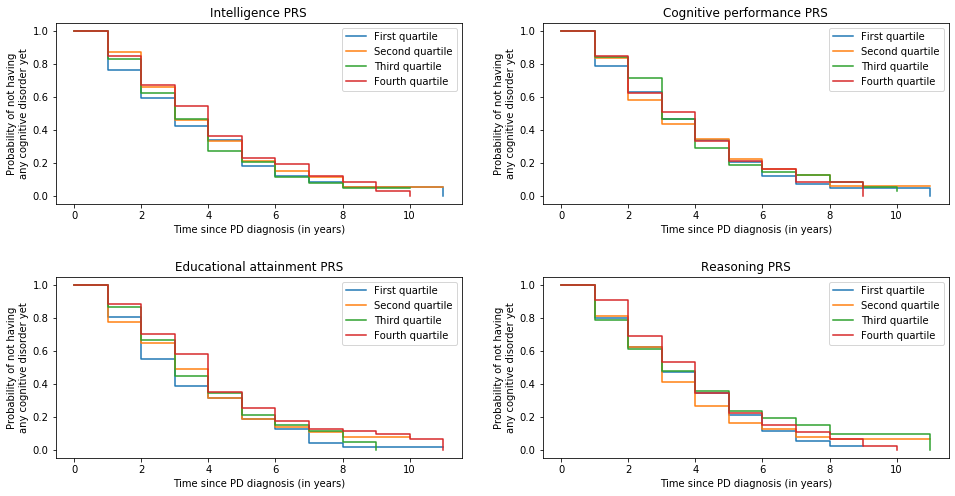

In [7]:
plot_kaplan_meier_curves_digpd(df_digpd, df_grs_digpd)

# Iceberg

In [8]:
subjects_iceberg = np.loadtxt('ICEBERG - final list of subjects.txt', dtype=int)

In [9]:
df_iceberg = pd.read_excel('ICEBERG data/export_iceberg_31052021.xlsx', sheet_name='Neuropsy')
df_iceberg = df_iceberg.rename(
    columns={'num_sujet': 'PATNO', 'redcap_event_name': 'Visit', 'sexe': 'Sex', 'total_moca': 'MoCA'}
)
df_iceberg = df_iceberg[df_iceberg['PATNO'].isin(subjects_iceberg)]
df_iceberg = df_iceberg[~df_iceberg['MoCA'].isna()]

df_grs_iceberg = pd.read_csv('LDpred2 - Results/GRS - ICEBERG.csv', index_col=0)
df_grs_iceberg = df_grs_iceberg.sub(df_grs_iceberg.mean(axis=0)).div(df_grs_iceberg.std(axis=0))

In [10]:
def plot_kaplan_meier_curves_iceberg(df, df_grs):
    # Compute status and age at dementia
    df_dementia = df.groupby('PATNO')[['date_visite', 'MoCA']].apply(
        compute_age_dementia, 'date_visite', 'MoCA', MOCA_THRESHOLD
    )
    df_dementia.columns = ['Status', 'Time']
    
    # Compute time at PD diagnosis
    series_diagnosis = pd.read_excel(
        'ICEBERG data/export_iceberg_31052021.xlsx', sheet_name='Générales',
        usecols=['num_sujet', 'date_diag']
    )
    series_diagnosis = series_diagnosis.dropna()
    series_diagnosis = series_diagnosis.drop_duplicates()
    series_diagnosis = series_diagnosis[series_diagnosis['num_sujet'].isin(subjects_iceberg)]
    series_diagnosis.columns = ['PATNO', 'Diagnosis date']
    series_diagnosis = series_diagnosis.set_index('PATNO').squeeze()
    
    series_baseline = df_iceberg.groupby('PATNO')['date_visite'].min()

    # Compute the quartiles for each GRS
    df_grs_quartiles = pd.DataFrame([
        pd.qcut(df_grs[col], 4, labels=False).squeeze() for col in significant_prs
    ]).T
    
    # Concatenate the objects
    df_new = pd.concat((series_diagnosis, series_baseline, df_dementia, df_grs_quartiles),
                       axis=1, join='inner')
    df_new['Time since diagnosis'] = (df_new['Time'] - df_new['Diagnosis date']).astype('timedelta64[D]') / 365.25
    df_new['Time since baseline'] = (df_new['Time'] - df_new['date_visite']).astype('timedelta64[D]') / 365.25
    
    print("Number of PD subjects =", df_new.shape[0])
    print()
    print(df_new['Status'].value_counts())
    
    # Plot Kaplan-Meier curves
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw={'hspace': 0.4})
    
    for i, (col, title) in enumerate(zip(significant_prs, titles)):
        idx = divmod(i, 2)
        
        for j, label in enumerate(['First quartile', 'Second quartile', 'Third quartile', 'Fourth quartile']):
            mask = (df_new[col] == j)

            axes[idx].step(*kaplan_meier_estimator(
                df_new.loc[mask, 'Status'],
                df_new.loc[mask, 'Time since diagnosis'].round(),
                df_new.loc[mask, 'Time since baseline'].round()
            ), where="post", label=label)

        axes[idx].legend()
        axes[idx].set_title(title)
        axes[idx].set_ylabel("Probability of not being demented yet")
        axes[idx].set_xlabel("Time since PD diagnosis (in years)")
        
    fig.savefig('Survival plots (ICEBERG).png', bbox_inches='tight', dpi=600)

Number of PD subjects = 144

False    109
True      35
Name: Status, dtype: int64


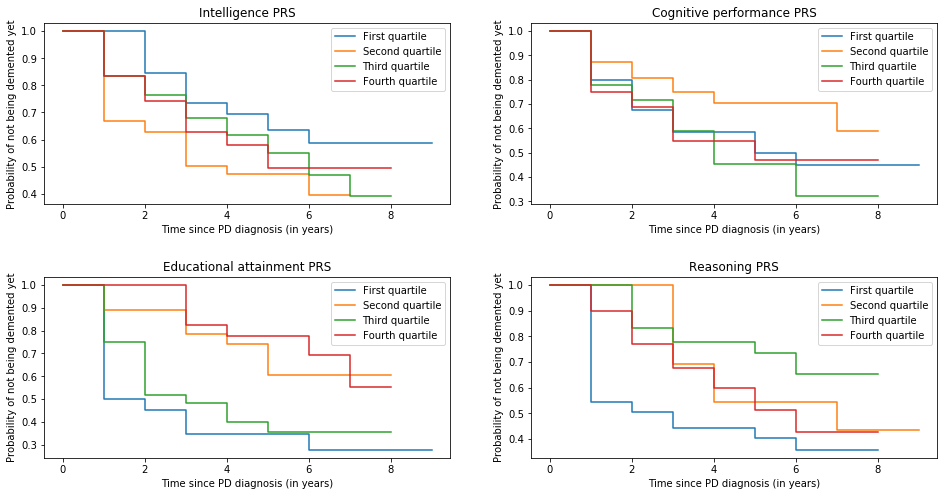

In [11]:
plot_kaplan_meier_curves_iceberg(df_iceberg, df_grs_iceberg)

# AMP PD

In [12]:
def plot_kaplan_meier_curves_apmpd(df, fname=None):
    df_new = df.dropna().copy()
    
    # Plot Kaplan-Meier curves
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw={'hspace': 0.4})

    for i, (col, title) in enumerate(zip(significant_prs, titles)):
        idx = divmod(i, 2)

        for j, label in enumerate(['First quartile', 'Second quartile', 'Third quartile', 'Fourth quartile']):
            mask = (df_new[col[:-4] + '_q'] == j)

            axes[idx].step(*kaplan_meier_estimator(
                df_new.loc[mask, 'MOCA25_EV'].astype(bool),
                df_new.loc[mask, 'cogimpair_TIME_FROM_DIAGNOSIS'].round(),
                df_new.loc[mask, 'YEARS_DIAGNOSIS_TO_BL'].round()
            ), where="post", label=label)

        axes[idx].legend()
        axes[idx].set_title(title)
        axes[idx].set_ylabel("Probability of not having\nany cognitive disorder yet")
        axes[idx].set_xlabel("Time since PD diagnosis (in years)")
    
    if fname is not None:
        fig.savefig(f'Survival plots ({fname}).png', bbox_inches='tight', dpi=600)

In [13]:
df_ppmi = pd.read_csv('Manuela - survival stuff/cog_impairment/PPMI_cogimpairment.tab', sep='\t')
df_pdbp = pd.read_csv('Manuela - survival stuff/cog_impairment/PDBP_cogimpairment.tab', sep='\t')
df_sure = pd.read_csv('Manuela - survival stuff/cog_impairment/Sure_cogimpairment.tab', sep='\t')
df_lcc = pd.read_csv('Manuela - survival stuff/cog_impairment/LCC_cogimpairment.tab', sep='\t')

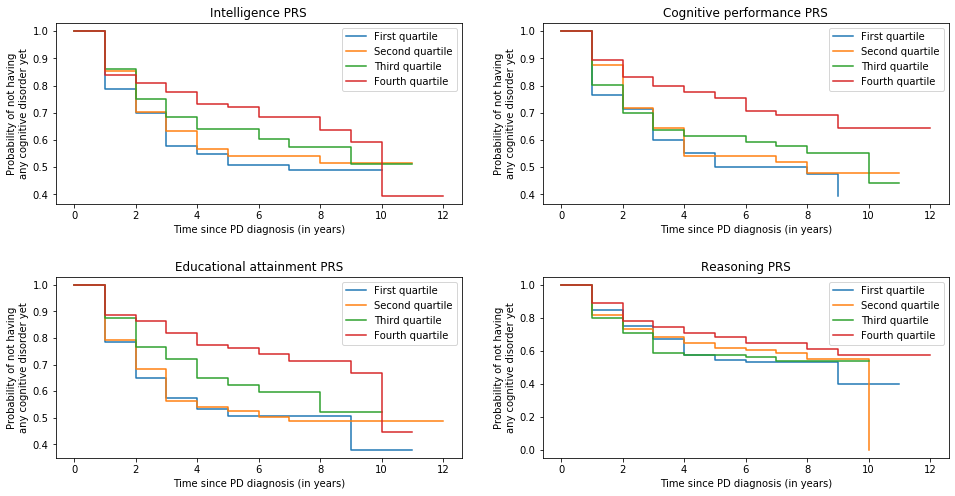

In [14]:
plot_kaplan_meier_curves_apmpd(df_ppmi, 'PPMI')

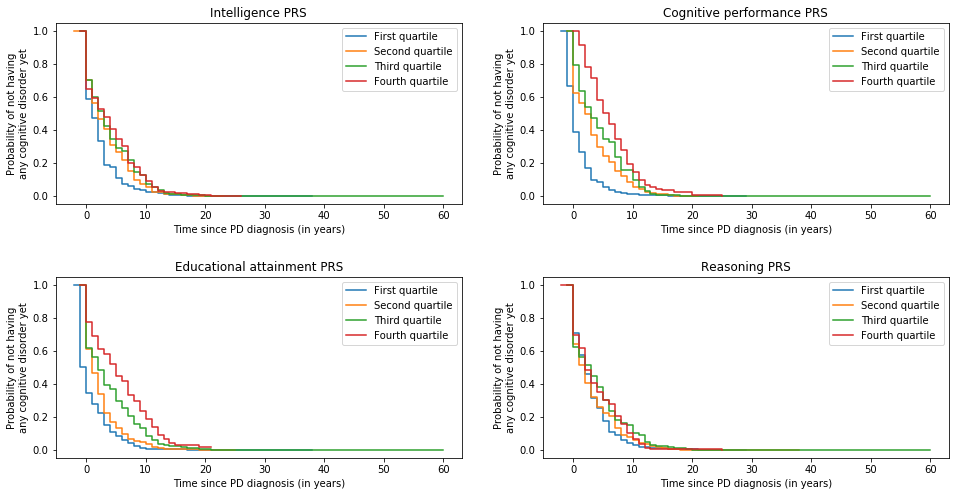

In [15]:
plot_kaplan_meier_curves_apmpd(df_pdbp, 'PDBP')

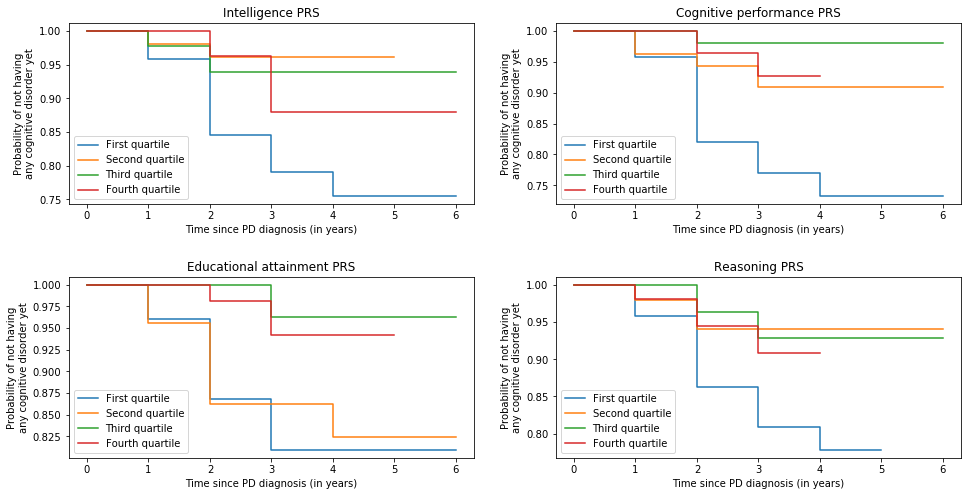

In [16]:
plot_kaplan_meier_curves_apmpd(df_sure, 'SURE-PD3')

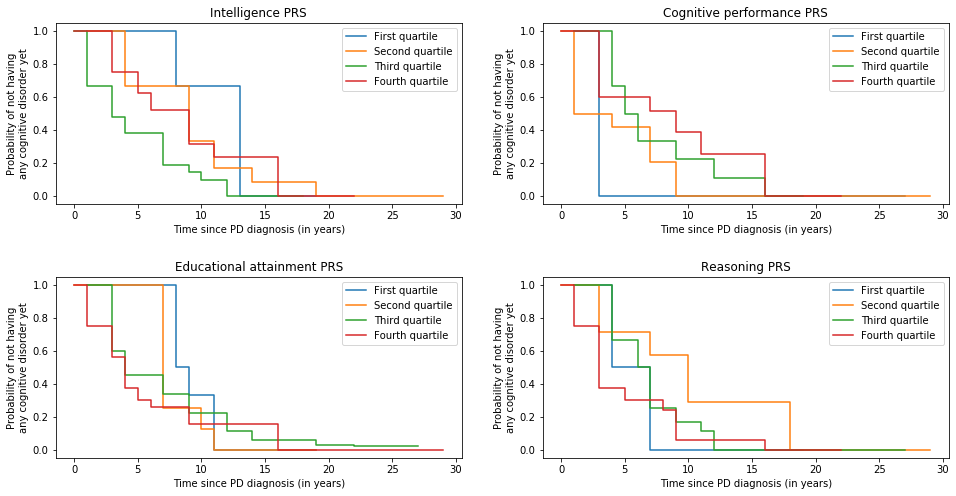

In [17]:
plot_kaplan_meier_curves_apmpd(df_lcc, 'LCC')

In [18]:
df_amppd = pd.concat((df_ppmi, df_pdbp, df_sure, df_lcc))
df_amppd.rename(
    columns={'MOCA25_EV': 'Status',
             'cogimpair_TIME_FROM_DIAGNOSIS': 'Time since diagnosis',
             'YEARS_DIAGNOSIS_TO_BL': 'Time since baseline'},
    inplace=True
)

In [19]:
def compute_df_digpd(df, df_grs):
    # Compute age at PD diagnosis
    series_age_diag = df_digpd.groupby('PATNO')['Age_diag'].min()
    series_baseline = df.groupby('PATNO')['AgeInclusion'].min()
    
    # Compute status and age at dementia
    df_dementia = df[~df['ScoreMMSE_Corrige'].isna()].copy()
    df_dementia = df_dementia.groupby('PATNO')[['Age', 'ScoreMMSE_Corrige']].apply(
        compute_age_dementia, 'Age', 'ScoreMMSE_Corrige', MMSE_THRESHOLD
    )
    df_dementia.columns = ['Status', 'Time']

    # Compute the quartiles for each GRS
    df_grs_quartiles = pd.DataFrame([
        pd.qcut(df_grs[col], 4, labels=False).squeeze() for col in significant_prs
    ]).T
    df_grs_quartiles.columns = [col[:-4] + '_q' for col in df_grs_quartiles.columns]
    
    # Concatenate the objects
    df_new = pd.concat((series_age_diag, series_baseline, df_dementia, df_grs_quartiles), axis=1, join='inner')
    df_new['Time since diagnosis'] = df_new['Time'] - df_new['Age_diag']
    df_new['Time since baseline'] = df_new['Time'] - df_new['AgeInclusion']
    
    return df_new

In [20]:
def compute_df_iceberg(df, df_grs):
    # Compute status and age at dementia
    df_dementia = df.groupby('PATNO')[['date_visite', 'MoCA']].apply(
        compute_age_dementia, 'date_visite', 'MoCA', MOCA_THRESHOLD
    )
    df_dementia.columns = ['Status', 'Time']
    
    # Compute time at PD diagnosis
    series_diagnosis = pd.read_excel(
        'ICEBERG data/export_iceberg_31052021.xlsx', sheet_name='Générales',
        usecols=['num_sujet', 'date_diag']
    )
    series_diagnosis = series_diagnosis.dropna()
    series_diagnosis = series_diagnosis.drop_duplicates()
    series_diagnosis = series_diagnosis[series_diagnosis['num_sujet'].isin(subjects_iceberg)]
    series_diagnosis.columns = ['PATNO', 'Diagnosis date']
    series_diagnosis = series_diagnosis.set_index('PATNO').squeeze()
    
    series_baseline = df_iceberg.groupby('PATNO')['date_visite'].min()

    # Compute the quartiles for each GRS
    df_grs_quartiles = pd.DataFrame([
        pd.qcut(df_grs[col], 4, labels=False).squeeze() for col in significant_prs
    ]).T
    df_grs_quartiles.columns = [col[:-4] + '_q' for col in df_grs_quartiles.columns]
    
    # Concatenate the objects
    df_new = pd.concat((series_diagnosis, series_baseline, df_dementia, df_grs_quartiles),
                       axis=1, join='inner')
    df_new['Time since diagnosis'] = (df_new['Time'] - df_new['Diagnosis date']).astype('timedelta64[D]') / 365.25
    df_new['Time since baseline'] = (df_new['Time'] - df_new['date_visite']).astype('timedelta64[D]') / 365.25
    
    return df_new

In [21]:
columns = [
    'Time since diagnosis', 'Time since baseline', 'Status',
    'GRS__savage_2018__intelligence_q', 'GRS__lee_2018__cognitive_performance_q',
    'GRS__lee_2018__educational_attainment_q', 'GRS__davies_2016__reasoning_q'
]

df_merged = pd.concat((
    compute_df_digpd(df_digpd, df_grs_digpd)[columns],
    compute_df_iceberg(df_iceberg, df_grs_iceberg)[columns],
    df_amppd[columns]
)).dropna(subset=['Time since diagnosis'])
df_merged['Status'] = df_merged['Status'].astype(bool)

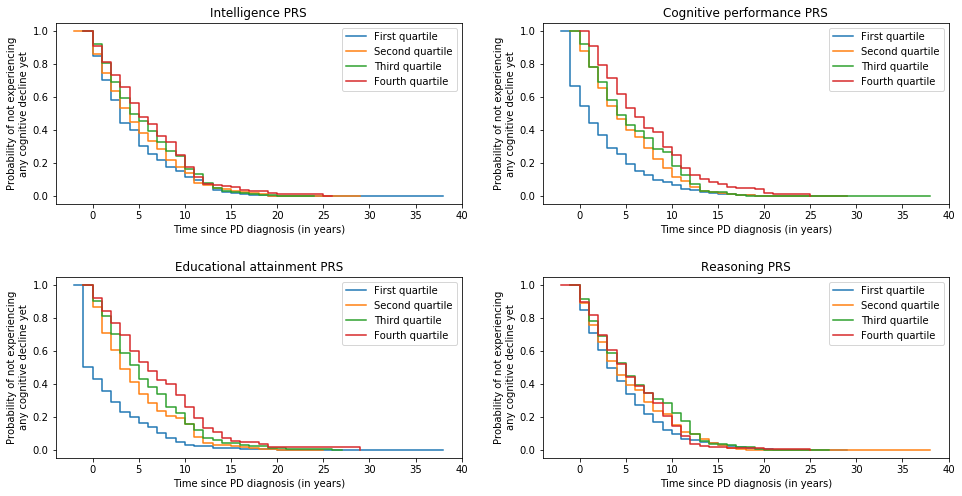

In [23]:
# Plot Kaplan-Meier curves
fig, axes = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw={'hspace': 0.4})

df_temp = df_merged[df_merged['Time since diagnosis'] < 40].copy()

for i, (col, title) in enumerate(zip(significant_prs, titles)):
    idx = divmod(i, 2)

    for j, label in enumerate(['First quartile', 'Second quartile', 'Third quartile', 'Fourth quartile']):
        mask = (df_temp[col[:-4] + '_q'] == j)

        axes[idx].step(*kaplan_meier_estimator(
            df_temp.loc[mask, 'Status'],
            df_temp.loc[mask, 'Time since diagnosis'].round(),
            df_temp.loc[mask, 'Time since baseline'].round()
        ), where="post", label=label)

    axes[idx].legend()
    axes[idx].set_title(title)
    axes[idx].set_ylabel("Probability of not experiencing\nany cognitive decline yet")
    axes[idx].set_xlabel("Time since PD diagnosis (in years)")

fig.savefig('Survival plots (merged).png', bbox_inches='tight', dpi=600)

In [55]:
for col in significant_prs:
    print(col)
    for q, label in zip((0, 3), ['First quartile', 'Fourth quartile']):
        mask = (df_temp[col[:-4] + '_q'] == q)

        time, prob_survival = kaplan_meier_estimator(
            df_temp.loc[mask, 'Status'],
            df_temp.loc[mask, 'Time since diagnosis'].round(),
            df_temp.loc[mask, 'Time since baseline'].round()
        )

        print(label, time[np.where(prob_survival > 0.5)[0][-1]])
    print()

GRS__savage_2018__intelligence.txt
First quartile 2.0
Fourth quartile 4.0

GRS__lee_2018__cognitive_performance.txt
First quartile 0.0
Fourth quartile 5.0

GRS__lee_2018__educational_attainment.txt
First quartile -2.0
Fourth quartile 5.0

GRS__davies_2016__reasoning.txt
First quartile 2.0
Fourth quartile 4.0



# Statistical comparison

In [24]:
df_merged.head()

,Time since diagnosis,Time since baseline,Status,GRS__savage_2018__intelligence_q,GRS__lee_2018__cognitive_performance_q,GRS__lee_2018__educational_attainment_q,GRS__davies_2016__reasoning_q
1001,5.749487,1.952088,True,1,1,3,2
1003,3.578371,1.029432,True,3,3,3,3
1004,3.813826,0.000000,True,2,1,2,1
1005,2.310746,0.000000,True,2,3,0,1
1007,4.117728,0.985626,True,2,3,2,3


In [25]:
X_structured = np.array(
    [(x, y) for x, y in df_merged[['Status', 'Time since diagnosis']].to_numpy()],
    dtype=[('status', np.bool_), ('time', np.float64)]
)

### All quartiles

In [26]:
compare_survival(X_structured, df_merged['GRS__savage_2018__intelligence_q'].to_numpy())

(9.968879605579325, 0.018832530981204867)

In [27]:
compare_survival(X_structured, df_merged['GRS__lee_2018__cognitive_performance_q'].to_numpy())

(20.25811685735321, 0.0001500663211052423)

In [28]:
compare_survival(X_structured, df_merged['GRS__lee_2018__educational_attainment_q'].to_numpy())

(24.825040452117236, 1.6797244590913148e-05)

In [29]:
compare_survival(X_structured, df_merged['GRS__davies_2016__reasoning_q'].to_numpy())

(9.85357250583294, 0.019852722738787163)

### Only first and last quartiles

In [40]:
idx_intelligence = np.where(df_merged['GRS__savage_2018__intelligence_q'].isin([0, 3]))[0]

compare_survival(
    X_structured[idx_intelligence],
    df_merged['GRS__savage_2018__intelligence_q'].to_numpy()[idx_intelligence]
)

(8.770218535799765, 0.0030618876025664513)

In [41]:
idx_cognitive_performance = np.where(df_merged['GRS__lee_2018__cognitive_performance_q'].isin([0, 3]))[0]

compare_survival(
    X_structured[idx_cognitive_performance],
    df_merged['GRS__lee_2018__cognitive_performance_q'].to_numpy()[idx_cognitive_performance]
)

(18.697722403729752, 1.5316532802636538e-05)

In [42]:
idx_educational_attainment = np.where(df_merged['GRS__lee_2018__educational_attainment_q'].isin([0, 3]))[0]

compare_survival(
    X_structured[idx_educational_attainment],
    df_merged['GRS__lee_2018__educational_attainment_q'].to_numpy()[idx_educational_attainment]
)

(18.988160418512365, 1.3153208165156242e-05)

In [43]:
idx_reasoning = np.where(df_merged['GRS__davies_2016__reasoning_q'].isin([0, 3]))[0]

compare_survival(
    X_structured[idx_reasoning],
    df_merged['GRS__davies_2016__reasoning_q'].to_numpy()[idx_reasoning]
)

(4.737482904912537, 0.02951222054002489)